**CIFAR-10 classification**

In [1]:
# Import necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.nn import functional as F

**Task 1: Read dataset and create dataloaders**

In [2]:
# Define the transformations to be applied to the training and test sets
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), # Randomly crop the images to size 32x32 with padding of 4 pixels
    transforms.RandomHorizontalFlip(), # Randomly flip the images horizontally
    transforms.ToTensor(), # Convert the images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.2, 0.2, 0.2)), # Normalize the pixel values with a mean and standard deviation
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.2, 0.2, 0.2)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train) # Training set with the defined transformations

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=256, shuffle=True, num_workers=2) # DataLoader for the training set

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)  # Test set with the defined transformations

testloader = torch.utils.data.DataLoader(
    testset, batch_size=256, shuffle=False, num_workers=2)  # DataLoader for the test set

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck') # Class names for the labels

Files already downloaded and verified
Files already downloaded and verified


**Task 2: Create the model**

In [3]:
# Define the Backbone class
class Backbone(nn.Module):
    def __init__(self, input_channels, num_channels, k=3, use_1x1conv=False, strides=1):
        super(Backbone, self).__init__()
        # Define the layers to be used in the forward pass
        self.spatialav = nn.AdaptiveAvgPool2d((1, 1))   # Adaptive average pooling layer to reduce the spatial dimensions of the input to 1x1
        self.linear = nn.Linear(input_channels, k)      # Linear layer to reduce the number of channels to k
        self.convs = nn.ModuleList([nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides, bias=False) for i in range(k)])   # k parallel convolutional layers
        self.k = k
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1, bias=False)   # Convolutional layer to operate on the output of the parallel convolutional layers
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides, bias=False)   # Optional 1x1 convolutional layer to change the number of input channels
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)   # Batch normalization layer to normalize the output of the parallel convolutional layers
        self.bn2 = nn.BatchNorm2d(num_channels)   # Batch normalization layer to normalize the final output        
    
    def forward(self, X):
        # Apply adaptive average pooling and linear layers to reduce the input to a vector of size k
        L = self.spatialav(X)
        L = L.view(L.size(0), -1)
        L = self.linear(L)
        L = F.relu(L)
        conv_outputs = []
        for i in range(self.k):
            # Apply the k parallel convolutional layers to the input and multiply each output by a corresponding weight from the vector obtained in the previous step
            conv_output = self.convs[i](X)
            L_expanded = L[:, i:i+1].unsqueeze(-1).unsqueeze(-1).expand_as(conv_output)
            conv_outputs.append(conv_output * L_expanded)
        # Add up the weighted outputs from the parallel convolutional layers and apply batch normalization and ReLU activation
        output = sum(conv_outputs)
        Y = F.relu(self.bn1(output))
        Y = self.bn2(self.conv2(output))       
        
        if self.conv3:
            # If self.conv3 exists, apply it to the input and add the output to the previous output
            X = self.conv3(X)      
        Y += X
        # Return the final output after applying ReLU activation
        return F.relu(Y) 

In [4]:
# Define a ResNet block using the basic Backbone class
def resnet_block(input_channels, num_channels, num_residuals, s=2,
                 first_block=False):
    # Initialize an empty list to store the Backbone blocks
    blk = []
    for i in range(num_residuals):
        # For the first block, use a 1x1 convolutional layer to change the number of input channels and adjust the stride
        if i == 0 and not first_block:
            blk.append(Backbone(input_channels, num_channels,use_1x1conv=True, strides=s ))
         # For subsequent blocks, use the same number of input and output channels and no change in stride
        else:
            blk.append(Backbone(num_channels, num_channels))
    # Return the list of Backbone blocks
    return blk

In [5]:
# Define each block
b1 = nn.Sequential(*resnet_block(3, 3, 2,first_block=True))
b2 = nn.Sequential(*resnet_block(3, 64, 2))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [6]:
#build model named net
net = nn.Sequential(# blocks
                    b1, b2, b3, b4, b5,
                    # classifer
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512,10))

**Task 3: Create the loss and optimizer**

In [7]:
#define lr, epochs, optimizer and scheduler
lr, num_epochs = 0.002, 100
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
#epochs 1-50 use lr 0.002, epochs 50-80 use lr 0.002*0.2, epochs 80-100 use lr 0.002*0.2*0.2
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,80], gamma=0.2) 

**Task 4: Training script**

In [8]:
import my_utils as mu
#define train progresss
def trainf(net, train_iter, test_iter, loss, num_epochs, optimizer, device):
    """Train and evaluate a model with CPU or GPU."""
    net.to(device)
    animator = mu.d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer = mu.d2l.Timer()
    for epoch in range(num_epochs):
        metric = mu.d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            net.train()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l*X.shape[0], mu.d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_loss, train_acc = metric[0]/metric[2], metric[1]/metric[2]
            if (i+1) % 50 == 0:
                animator.add(epoch + i/len(train_iter),
                              (train_loss, train_acc, None))
        test_acc = mu.evaluate_accuracy_gpu(net, test_iter)
        scheduler.step() # dynamic adjust lr
        animator.add(epoch+1, (None, None, test_acc))
    print(f'loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

**Task 5: Final model accuracy on CIFAR-10 Validation Set**

loss 0.079, train acc 0.971, test acc 0.887
7604.3 examples/sec on cuda


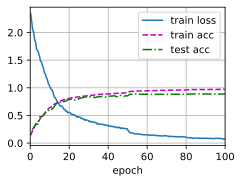

In [9]:
#show the train progress and result
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
trainf(net, trainloader, testloader, loss, num_epochs, optimizer, device)